<a href="https://colab.research.google.com/github/turnleftorgo/Image-Semantic-Segmentation-with-EfficientNet-B0-fine-tuning/blob/main/FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import library
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42) # For reproduciblity purpose, please do not modify this.

## Helper functions and dataset setup

##1. Download dataset
Please refer to [this function](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.VOCSegmentation.html) from TorchVision to download the Pascal VOC Segmentation Dataset.

Note that you can change the input of provided code to match with your requirement.

Because the Pascal VOC Segmentation Dataset 2012 only provide a `train` set and a `val` set. So that you are required to train on `train` set only and then test the model on `val` set

**Note:** There is a void class with index 255 in dataset, you can treat the pixels with this label as backbround or just simply ignore it when calculate the loss value. [Refer to this post for suggestion](https://discuss.pytorch.org/t/having-trouble-with-voc-2012-segmentation-with-the-void-255-label/46486/7)

In [ ]:
voc_dir = './data'
os.makedirs(voc_dir, exist_ok=True)

def mask_to_tensor(mask):
    """palette PNG -> LongTensor (H, W)"""
    return torch.from_numpy(np.array(mask, dtype=np.uint8)).long()

input_size = (224, 224)

img_transform = T.Compose([
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize(input_size, interpolation=T.InterpolationMode.NEAREST),
    mask_to_tensor                               ])


train_dataset = VOCSegmentation(root=voc_dir, year="2012", image_set="train", download=True,transform=img_transform,
    target_transform=mask_transform)
val_dataset = VOCSegmentation(root=voc_dir, year="2012", image_set="val", download=True,transform=img_transform,
    target_transform=mask_transform)

VOC_CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
               "bus", "car",  "cat",  "chair", "cow",  "diningtable", "dog", "horse",
               "motorbike", "person","potted plant", "sheep", "sofa","train", "tv/monitor"]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

100%|██████████| 2.00G/2.00G [00:36<00:00, 55.5MB/s]


In [ ]:
from torch.utils.data import  DataLoader
# Create dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

##2. Helper function
You are required to use this helper function to calculate the mean IoU score

In [ ]:
# Provided meanIoU score
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_segmentation_metrics(preds, masks, num_classes, ignore_index=0):
    """
    Computes segmentation metrics: per-class and mean Precision, Recall, IoU, Dice, and overall Pixel Accuracy.

    Args:
        preds (Tensor): Predicted segmentation masks (B, H, W), each element is the predicted index class
        masks (Tensor): Ground truth segmentation masks (B, H, W)
        num_classes (int): Number of classes including background
        ignore_index (int): Label to ignore in evaluation (e.g., it should be the index of the background)

    Returns:
        metrics (dict): Dictionary containing:
            - 'per_class': dict of per-class metrics
            - 'mean_metrics': dict of averaged metrics across foreground classes
            - 'pixel_accuracy': float, overall pixel accuracy (excluding ignored)
    """
    eps = 1e-6  # for numerical stability
    preds = preds.view(-1)
    masks = masks.view(-1)
    valid = masks != ignore_index

    preds = preds[valid]
    masks = masks[valid]

    per_class_metrics = {}
    total_correct = 0
    total_pixels = valid.sum().item()

    precision_list = []
    recall_list = []
    iou_list = []
    dice_list = []

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = masks == cls

        TP = (pred_inds & target_inds).sum().item()
        FP = (pred_inds & ~target_inds).sum().item()
        FN = (~pred_inds & target_inds).sum().item()
        TN = ((~pred_inds) & (~target_inds)).sum().item()

        union = TP + FP + FN
        pred_sum = pred_inds.sum().item()
        target_sum = target_inds.sum().item()

        if target_sum == 0 and pred_sum == 0:
            continue

        precision = TP / (TP + FP + eps)
        recall = TP / (TP + FN + eps)
        iou = TP / (union + eps)
        dice = (2 * TP) / (pred_sum + target_sum + eps)

        precision_list.append(precision)
        recall_list.append(recall)
        iou_list.append(iou)
        dice_list.append(dice)

        total_correct += TP

    pixel_accuracy = total_correct / (total_pixels + eps)

    return {
        "precision": sum(precision_list) / len(precision_list),
        "recall": sum(recall_list) / len(recall_list),
        "iou": sum(iou_list) / len(iou_list),
        "dice": sum(dice_list) / len(dice_list),
        "pixel_accuracy": pixel_accuracy,
    }

In [ ]:
import matplotlib.pyplot as plt

def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        data_iter = iter(test_loader)
        inputs, masks = next(data_iter)
        inputs = inputs.to(device)
        # Make predictions
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()
        preds = preds.float()
        # Display the results
        for j in range(min(10, inputs.shape[0])):
            visualize_sample([inputs[j], masks[j], preds[j].float()],
                    titles=['Input Image', 'True Mask', 'Predicted Mask'])


In [ ]:
def visualize_sample(display_list, titles=['Input Image', 'True Mask', 'Predicted Mask']):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])

        if isinstance(display_list[i], torch.Tensor):
            img = display_list[i].detach().cpu().numpy()


            if len(img.shape) == 3 and img.shape[0] == 3:
                img = np.transpose(img, (1, 2, 0))

                if i == 0:
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)


            elif len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[0] == 1):
                if len(img.shape) == 3:
                    img = img.squeeze(0)


                if i > 0:
                    num_classes = int(img.max()) + 1

                    colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
                    colored_mask = colors[img.astype(int)]
                    img = colored_mask
        else:
            img = display_list[i]

        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Task 1: Build a baseline Fully Convolutional Network (FCN) model for semantic segmentation (5 marks)

In [ ]:
backbone_efficientnet = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub",  "nvidia_efficientnet_b0", pretrained=True)    # Note: You can modify this code to load the backbone_efficientnet, just make sure you use model and weights from Nvidia

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
backbone_efficientnet.classifier = nn.Identity()

In [ ]:
class BaselineFCN(nn.Module):
    def __init__(self, backbone_efficientnet, freeze_backbone_efficientnet=False):

        super().__init__()
        self.backbone_efficientnet = backbone_efficientnet

        if freeze_backbone_efficientnet:
            for p in self.backbone_efficientnet.parameters():
                p.requires_grad_(False)

        self.project = nn.Sequential(
            nn.Conv2d(1280, 21, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.ConvTranspose2d(
            21, 21, kernel_size=64, stride=32, padding=16,bias = False
        )

    def forward(self, x):
        x = self.backbone_efficientnet(x)
        x = self.project(x)
        x = self.upsample(x)
        return x


In [ ]:
basic_model = BaselineFCN(backbone_efficientnet=backbone_efficientnet).to(device)




total = 0
for name, param in basic_model.named_parameters():
    if param.requires_grad:          # skip frozen layers if any
        n_param = param.numel()
        print(f"{name:30s}  shape={tuple(param.shape)!s:15}  n={n_param:>8,d}")
        total += n_param

print(f"\nTOTAL TRAINABLE PARAMETERS: {total:,}")

backbone_efficientnet.stem.conv.weight  shape=(32, 3, 3, 3)    n=     864
backbone_efficientnet.stem.bn.weight  shape=(32,)            n=      32
backbone_efficientnet.stem.bn.bias  shape=(32,)            n=      32
backbone_efficientnet.layers.0.block0.depsep.conv.weight  shape=(32, 1, 3, 3)    n=     288
backbone_efficientnet.layers.0.block0.depsep.bn.weight  shape=(32,)            n=      32
backbone_efficientnet.layers.0.block0.depsep.bn.bias  shape=(32,)            n=      32
backbone_efficientnet.layers.0.block0.se.squeeze.weight  shape=(8, 32)          n=     256
backbone_efficientnet.layers.0.block0.se.squeeze.bias  shape=(8,)             n=       8
backbone_efficientnet.layers.0.block0.se.expand.weight  shape=(32, 8)          n=     256
backbone_efficientnet.layers.0.block0.se.expand.bias  shape=(32,)            n=      32
backbone_efficientnet.layers.0.block0.proj.conv.weight  shape=(16, 32, 1, 1)   n=     512
backbone_efficientnet.layers.0.block0.proj.bn.weight  shape=(16,) 

In [ ]:
from torchsummary import summary
summary(basic_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
            Linear-7                    [-1, 8]             264
              SiLU-8                    [-1, 8]               0
            Linear-9                   [-1, 32]             288
          Sigmoid-10                   [-1, 32]               0
SequentialSqueezeAndExcitation-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]             512
      BatchNorm2d-13         [-1, 16, 112, 112]              32
      MBConvBlock-14      

## Training process

In [ ]:
import torch

NUM_VOC_CLASSES = len(VOC_CLASSES)

def train_model_new(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):

    model.train()

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_iou': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_iou': []
    }

    num_classes = NUM_VOC_CLASSES
    ignore_index = 0

    for epoch in range(num_epochs):

        running_loss = 0.0
        running_accuracy = 0.0
        running_iou = 0.0


        for inputs, masks in train_loader:

            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            if scheduler:
                scheduler.step()

            # Compute metrics for the batch
            preds = torch.argmax(outputs, dim=1)
            metrics = calculate_segmentation_metrics(preds, masks, num_classes, ignore_index)
            batch_accuracy = metrics['pixel_accuracy']
            batch_iou = metrics['iou']

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += batch_accuracy * inputs.size(0)
            running_iou += batch_iou * inputs.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['train_iou'].append(epoch_iou)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Train IoU: {epoch_iou:.4f}')

        # Validation
        val_loss, val_accuracy, val_iou = evaluate_model(model, val_loader, criterion, num_classes, ignore_index)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_iou'].append(val_iou)

        print(f'               Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val IoU: {val_iou:.4f}')

    return history

def evaluate_model(model, test_loader, criterion, num_classes, ignore_index=0):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for inputs, masks in test_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())

    test_loss = running_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    metrics = calculate_segmentation_metrics(all_preds, all_masks, num_classes, ignore_index)
    test_accuracy = metrics['pixel_accuracy']
    test_iou = metrics['iou']


    return test_loss, test_accuracy, test_iou

In [ ]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(basic_model.parameters(), lr=learning_rate)
num_epochs = 30

In [ ]:
history1 = train_model_new(basic_model, train_loader, test_loader, loss_fn, optimizer, num_epochs= num_epochs, scheduler=None)

Epoch 1, Train Loss: 1.3520, Train Accuracy: 0.0528, Train IoU: 0.0183
               Val Loss: 0.9479, Val Accuracy: 0.1520, Val IoU: 0.0369
Epoch 2, Train Loss: 0.8285, Train Accuracy: 0.1863, Train IoU: 0.0666
               Val Loss: 0.7763, Val Accuracy: 0.2357, Val IoU: 0.1006
Epoch 3, Train Loss: 0.6839, Train Accuracy: 0.2830, Train IoU: 0.1138
               Val Loss: 0.6738, Val Accuracy: 0.3300, Val IoU: 0.1644
Epoch 4, Train Loss: 0.5501, Train Accuracy: 0.3723, Train IoU: 0.1760
               Val Loss: 0.5985, Val Accuracy: 0.3883, Val IoU: 0.2847
Epoch 5, Train Loss: 0.4775, Train Accuracy: 0.4401, Train IoU: 0.2323
               Val Loss: 0.6197, Val Accuracy: 0.4007, Val IoU: 0.3123
Epoch 6, Train Loss: 0.4187, Train Accuracy: 0.4967, Train IoU: 0.2888
               Val Loss: 0.6170, Val Accuracy: 0.3656, Val IoU: 0.2525
Epoch 7, Train Loss: 0.3831, Train Accuracy: 0.5297, Train IoU: 0.3221
               Val Loss: 0.5928, Val Accuracy: 0.4486, Val IoU: 0.3472
Epoch 

In [ ]:
file_name = "FCN1.pth"
torch.save(basic_model.state_dict(), file_name)

## Visualization_Reuslt

In [ ]:
import matplotlib.pyplot as plt

def visualize_training_results(history, num_epochs):
    epochs_range = range(num_epochs)

    plt.figure(figsize=(18, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot Mean IoU
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['train_iou'], label='Training Mean IoU')
    plt.plot(epochs_range, history['val_iou'], label='Validation Mean IoU')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

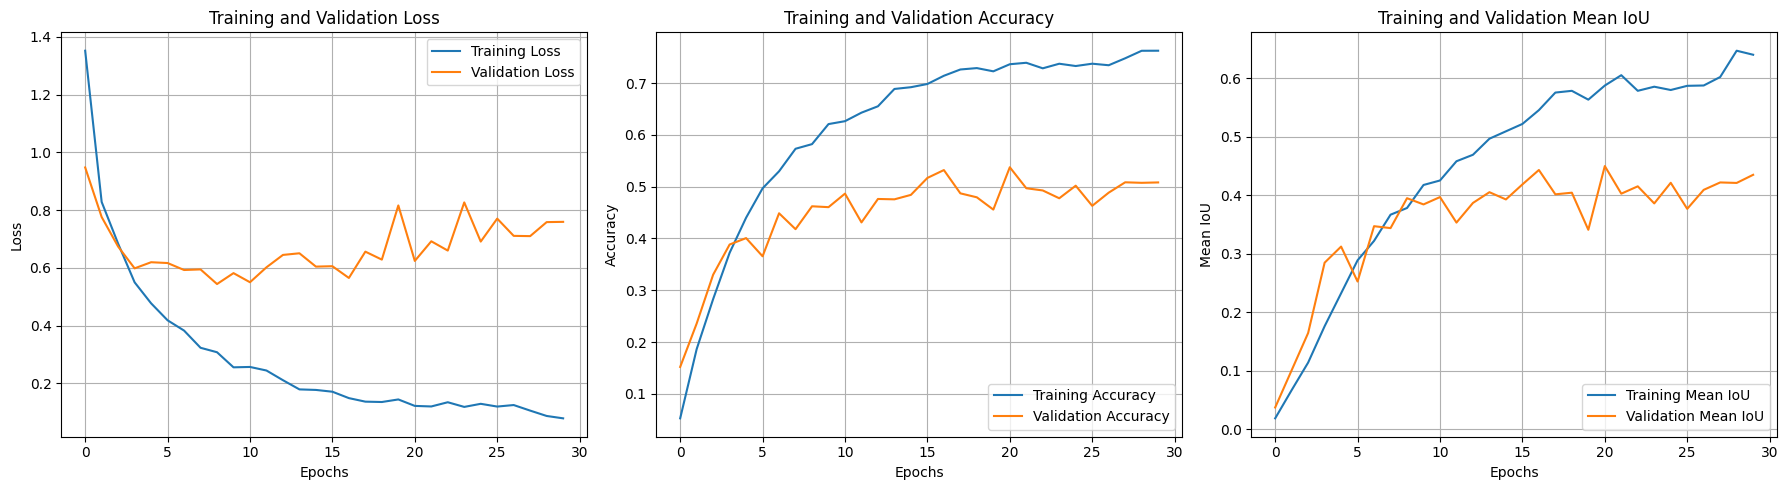

In [ ]:
visualize_training_results(history1, num_epochs)

## Visualsation_image

In [ ]:
!pip install gdown
! gdown --fuzzy https://drive.google.com/file/d/1EB8VX0nss_KiQvJAkKNq5Hro6kFEZYd3/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1EB8VX0nss_KiQvJAkKNq5Hro6kFEZYd3
To: /content/FCN1.pth
100% 23.7M/23.7M [00:00<00:00, 34.3MB/s]


In [ ]:
state_dict_1 = torch.load('/content/FCN1.pth')
basic_model.load_state_dict(state_dict_1)
basic_model.to(device)

BaselineFCN(
  (backbone_efficientnet): EfficientNet(
    (stem): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (layers): Sequential(
      (0): Sequential(
        (block0): MBConvBlock(
          (depsep): Sequential(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (se): SequentialSqueezeAndExcitation(
            (squeeze): Linear(in_features=32, out_features=8, bias=True)
            (expand): Linear(in_features=8, out_features=32, bias=True)
            (activation): SiLU(inplace=True)
            (sigmoid): Sigmoid()
            (mul_a_q

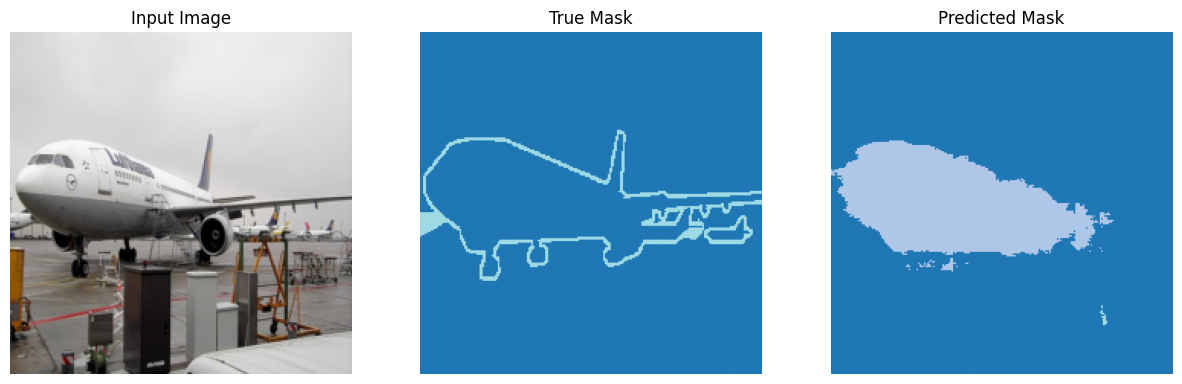

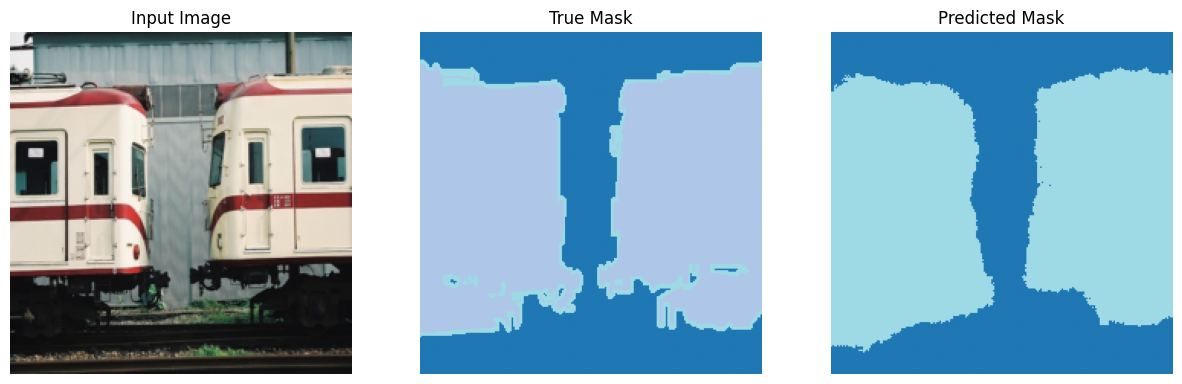

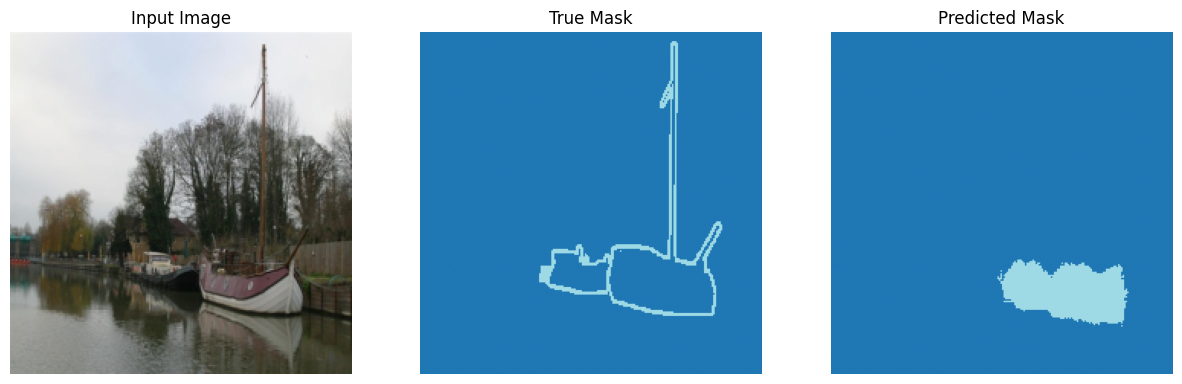

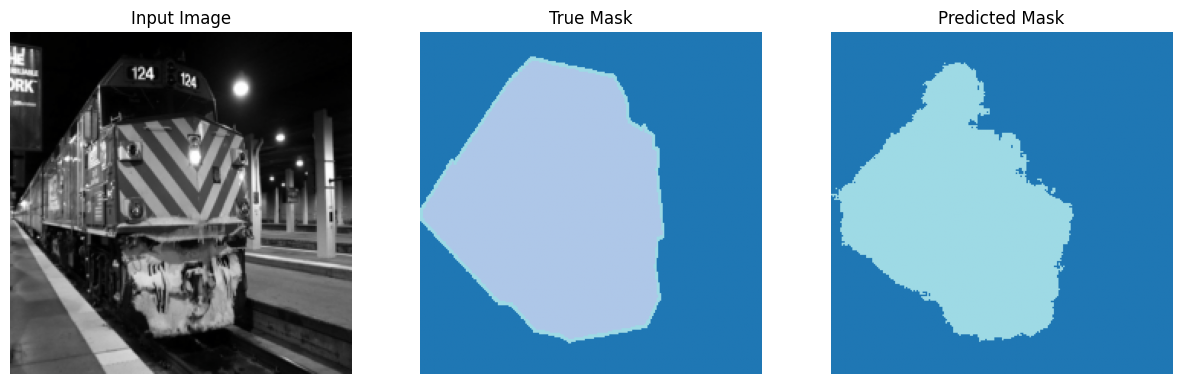

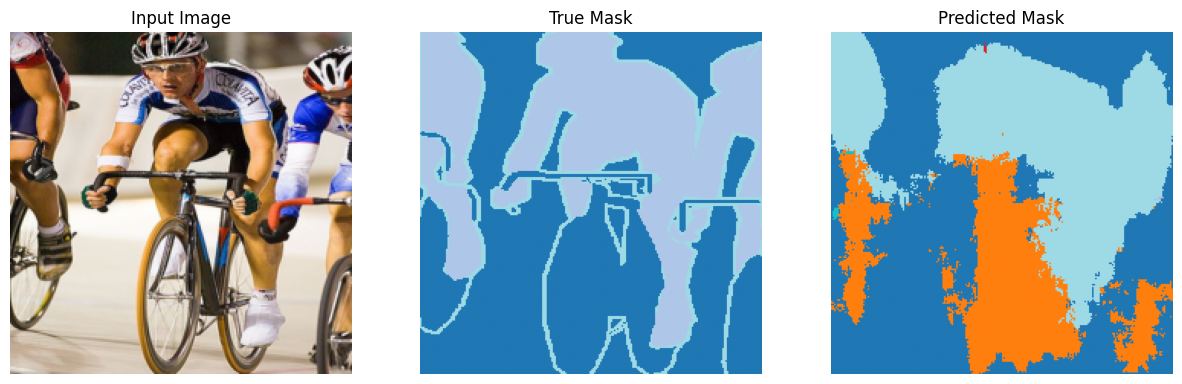

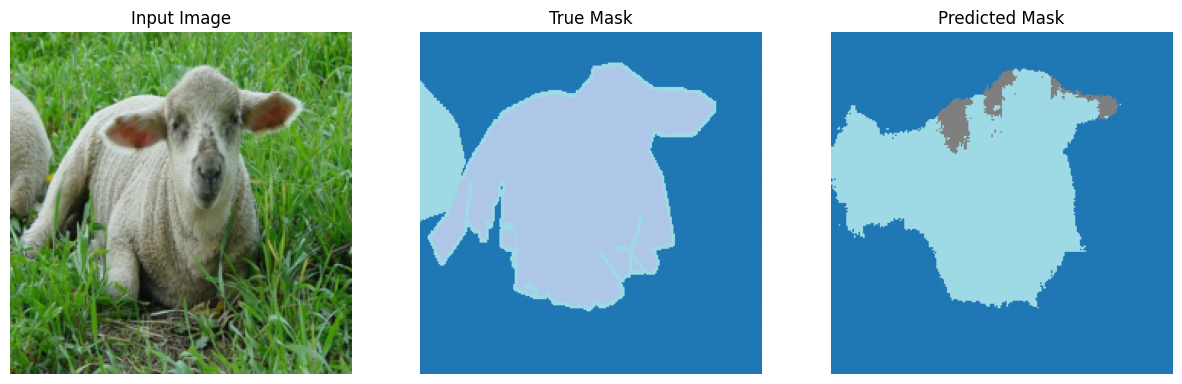

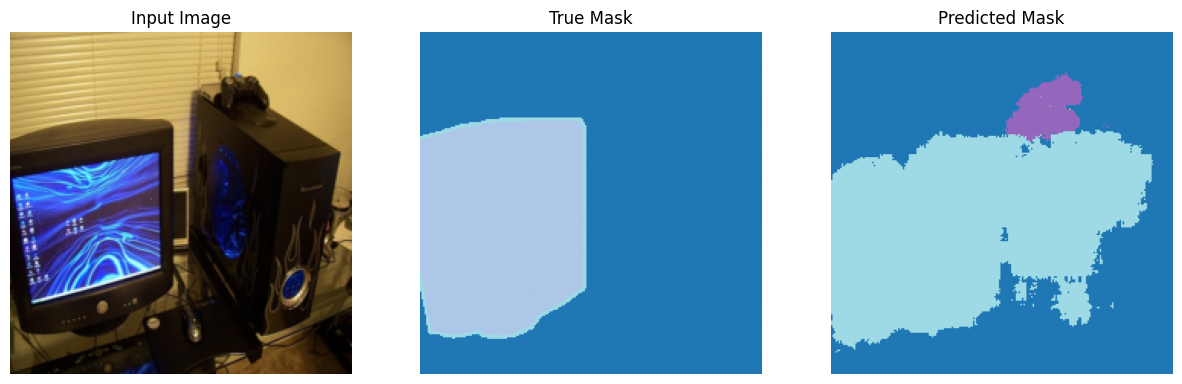

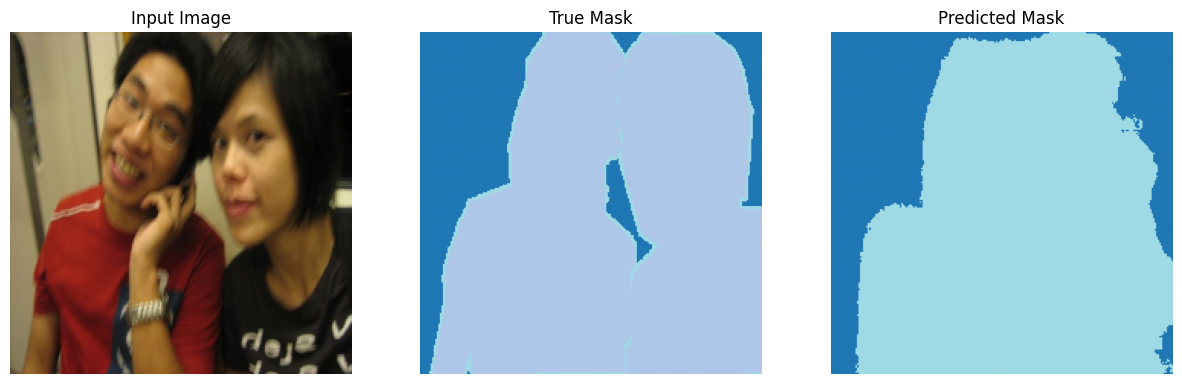

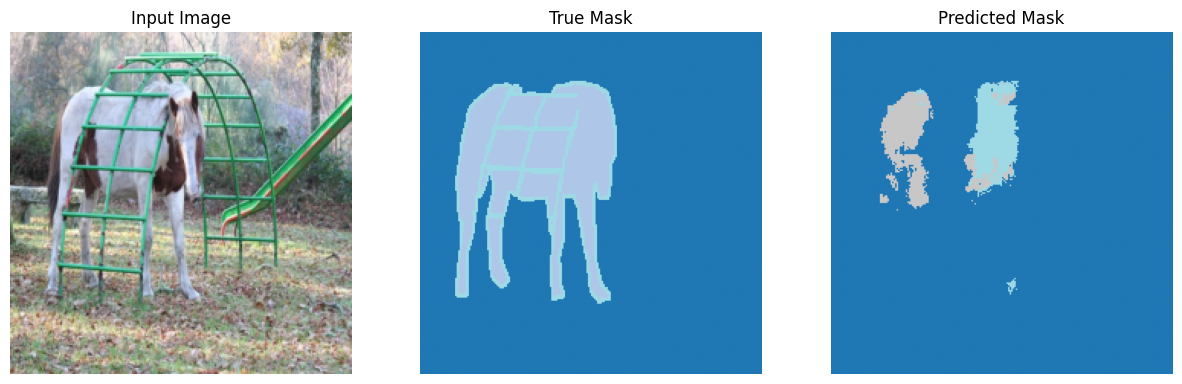

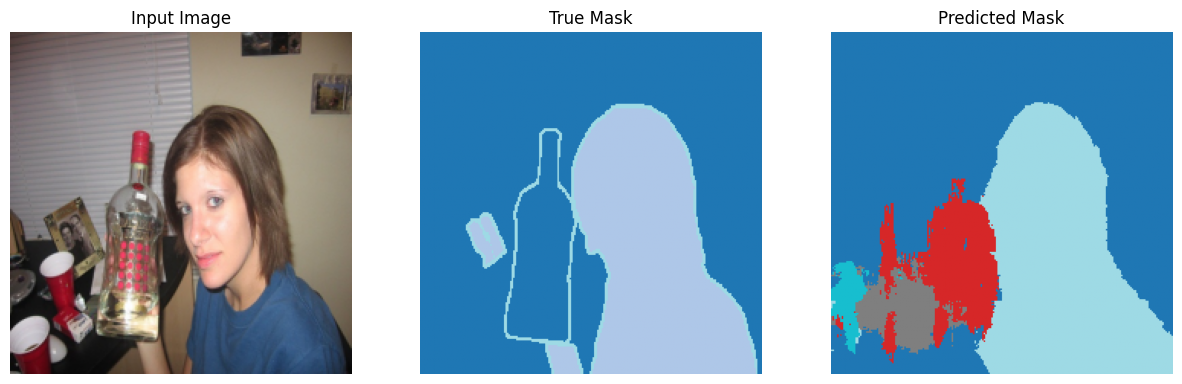

In [ ]:
predict(basic_model, test_loader)

# Task 2: Improve the baseline FCN model (8 marks)

In [ ]:
eff = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub",
                     "nvidia_efficientnet_b0", pretrained=False)
print([m for m in eff.named_children()])

# to see the structure of pre-trained model

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


[('stem', Sequential(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (activation): SiLU(inplace=True)
)), ('layers', Sequential(
  (0): Sequential(
    (block0): MBConvBlock(
      (depsep): Sequential(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (se): SequentialSqueezeAndExcitation(
        (squeeze): Linear(in_features=32, out_features=8, bias=True)
        (expand): Linear(in_features=8, out_features=32, bias=True)
        (activation): SiLU(inplace=True)
        (sigmoid): Sigmoid()
        (mul_a_quantizer): Identity()
        (mul_b_quantizer): Identity()
      )
      (proj): Sequential(
        (conv): Conv2d(32, 16, 

/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models


class RCU(nn.Module):

    def __init__(self, c):
        super().__init__()
        self.conv1 = nn.Conv2d(c, c, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1, bias=False)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        return out + x                        # short-range residual

class CRP(nn.Module):

    def __init__(self, c):
        super().__init__()
        self.pool1 = nn.AvgPool2d(5,1,2)
        self.conv1 = nn.Conv2d(c, c, 3, padding=1, bias=False)
        self.pool2 = nn.AvgPool2d(5,1,2)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1, bias=False)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        y = self.relu(self.conv1(self.pool1(x)))
        x = x + y
        y = self.relu(self.conv2(self.pool2(x)))
        return x + y                          # residual sum

In [ ]:
import torch, torch.nn as nn


def get_nvidia_efficientnet_b0_features(pretrained=True):

    eff = torch.hub.load("NVIDIA/DeepLearningExamples:torchhub",
                         "nvidia_efficientnet_b0", pretrained=pretrained)

    # get the important component of NVIDIA's pretrain model stem  layers , no need for head
    stem   = eff.stem
    blocks = eff.layers


    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()
            self.stem   = stem
            self.blocks = blocks

        def forward(self, x):
            out = self.stem(x)          # 224→112 , ch 32
            f4=f8=f16=f32=None          # 4 level feature


            for blk in self.blocks:     # 16 MBConv block in 7 个 Sequential

                prev_h = out.shape[2]
                out    = blk(out)
                h      = out.shape[2]

                if prev_h // h == 2:    # if downsampling
                    ratio = x.shape[2] // h
                    if   ratio == 4  and f4  is None: f4  = out  # 56 , ch 24
                    elif ratio == 8  and f8  is None: f8  = out  # 28 , ch 40
                    elif ratio == 16 and f16 is None: f16 = out  # 14 , ch 80
                    elif ratio == 32 and f32 is None: f32 = out  #  7 , ch 192

            f4  = f4  if f4  is not None else out
            f8  = f8  if f8  is not None else out
            f16 = f16 if f16 is not None else out
            f32 = f32 if f32 is not None else out
            return f4, f8, f16, f32

    return FeatureExtractor()


In [ ]:
class EfficientRefineNetB0(nn.Module):
    def __init__(self, num_classes=21, mid_channels=160, pretrained=True):
        super().__init__()

        self.backbone = get_nvidia_efficientnet_b0_features(pretrained)


        self.adapt4  = nn.Conv2d( 24, mid_channels, 1, bias=False)  # 56
        self.adapt8  = nn.Conv2d( 40, mid_channels, 1, bias=False)  # 28
        self.adapt16 = nn.Conv2d( 80, mid_channels, 1, bias=False)  # 14
        self.adapt32 = nn.Conv2d(192, mid_channels, 1, bias=False)  #  7



        self.rcu32 = RCU(mid_channels)

        self.rcu_coarse3 = RCU(mid_channels); self.rcu_fine3 = RCU(mid_channels)
        self.crp3 = CRP(mid_channels);        self.rcu_out3 = RCU(mid_channels)

        self.rcu_coarse2 = RCU(mid_channels); self.rcu_fine2 = RCU(mid_channels)
        self.crp2 = CRP(mid_channels);        self.rcu_out2 = RCU(mid_channels)

        self.rcu_coarse1 = RCU(mid_channels); self.rcu_fine1 = RCU(mid_channels)
        self.crp1 = CRP(mid_channels);        self.rcu_out1 = RCU(mid_channels)

        self.classifier = nn.Conv2d(mid_channels, num_classes, 1)


    def forward(self, x):

        f4, f8, f16, f32 = self.backbone(x)         # sizes 56 / 28 / 14 / 7

        # To align the channel

        f4  = self.adapt4(f4)
        f8  = self.adapt8(f8)
        f16 = self.adapt16(f16)
        f32 = self.adapt32(f32)

        # RefineNet-4  (1/32)
        r32 = self.rcu32(f32)

        # RefineNet-3  (1/16)
        r32_up = F.interpolate(r32, size=f16.shape[2:], mode='bilinear', align_corners=False)
        r16 = self.rcu_coarse3(r32_up) + self.rcu_fine3(f16)
        r16 = self.crp3(r16); r16 = self.rcu_out3(r16)

        # RefineNet-2  (1/8)
        r16_up = F.interpolate(r16, size=f8.shape[2:], mode='bilinear', align_corners=False)
        r8 = self.rcu_coarse2(r16_up) + self.rcu_fine2(f8)
        r8 = self.crp2(r8); r8 = self.rcu_out2(r8)

        # RefineNet-1  (1/4)
        r8_up = F.interpolate(r8, size=f4.shape[2:], mode='bilinear', align_corners=False)
        r4 = self.rcu_coarse1(r8_up) + self.rcu_fine1(f4)
        r4 = self.crp1(r4); r4 = self.rcu_out1(r4)

        # classify and upsampling
        logits_1_4 = self.classifier(r4)
        logits_full= F.interpolate(logits_1_4, size=x.shape[2:],
                                   mode='bilinear', align_corners=False)
        return logits_full


In [ ]:
model_ultra = EfficientRefineNetB0(num_classes=21).to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 13.4MB/s]


In [ ]:
total = 0
for name, param in model_ultra.named_parameters():
    if param.requires_grad:                                                       # for the paremeter number checking
        n_param = param.numel()
        print(f"{name:30s}  shape={tuple(param.shape)!s:15}  n={n_param:>8,d}")
        total += n_param

print(f"\nTOTAL TRAINABLE PARAMETERS: {total:,}")

backbone.stem.conv.weight       shape=(32, 3, 3, 3)    n=     864
backbone.stem.bn.weight         shape=(32,)            n=      32
backbone.stem.bn.bias           shape=(32,)            n=      32
backbone.blocks.0.block0.depsep.conv.weight  shape=(32, 1, 3, 3)    n=     288
backbone.blocks.0.block0.depsep.bn.weight  shape=(32,)            n=      32
backbone.blocks.0.block0.depsep.bn.bias  shape=(32,)            n=      32
backbone.blocks.0.block0.se.squeeze.weight  shape=(8, 32)          n=     256
backbone.blocks.0.block0.se.squeeze.bias  shape=(8,)             n=       8
backbone.blocks.0.block0.se.expand.weight  shape=(32, 8)          n=     256
backbone.blocks.0.block0.se.expand.bias  shape=(32,)            n=      32
backbone.blocks.0.block0.proj.conv.weight  shape=(16, 32, 1, 1)   n=     512
backbone.blocks.0.block0.proj.bn.weight  shape=(16,)            n=      16
backbone.blocks.0.block0.proj.bn.bias  shape=(16,)            n=      16
backbone.blocks.1.block0.expand.conv.wei

In [ ]:
import torch

NUM_VOC_CLASSES = len(VOC_CLASSES)

def train_model_new(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):

    model.train()

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_iou': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_iou': []
    }

    num_classes = NUM_VOC_CLASSES
    ignore_index = 0
    best_iou = -1

    for epoch in range(num_epochs):

        running_loss = 0.0
        running_accuracy = 0.0
        running_iou = 0.0


        for inputs, masks in train_loader:

            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            if scheduler:
                scheduler.step()

            # Compute metrics for the batch
            preds = torch.argmax(outputs, dim=1)
            metrics = calculate_segmentation_metrics(preds, masks, num_classes, ignore_index)
            batch_accuracy = metrics['pixel_accuracy']
            batch_iou = metrics['iou']

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += batch_accuracy * inputs.size(0)
            running_iou += batch_iou * inputs.size(0)


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_accuracy / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['train_iou'].append(epoch_iou)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Train IoU: {epoch_iou:.4f}')



        # Validation
        val_loss, val_accuracy, val_iou = evaluate_model(model, val_loader, criterion, num_classes, ignore_index)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_iou'].append(val_iou)

        print(f'               Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val IoU: {val_iou:.4f}')

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best valid iou so far is {best_iou:.4f}')

    return history

def evaluate_model(model, test_loader, criterion, num_classes, ignore_index=255):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for inputs, masks in test_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_masks.append(masks.cpu())

    test_loss = running_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    metrics = calculate_segmentation_metrics(all_preds, all_masks, num_classes, ignore_index)
    test_accuracy = metrics['pixel_accuracy']
    test_iou = metrics['iou']


    return test_loss, test_accuracy, test_iou


In [ ]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_ultra.parameters(), lr=learning_rate)
num_epochs = 70

history3 = train_model_new(model_ultra, train_loader, test_loader, loss_fn, optimizer, num_epochs= num_epochs, scheduler=None)

Epoch 1, Train Loss: 5.3153, Train Accuracy: 0.3557, Train IoU: 0.1715
               Val Loss: 0.7311, Val Accuracy: 0.3513, Val IoU: 0.2861
Best valid iou so far is 0.2861
Epoch 2, Train Loss: 0.6854, Train Accuracy: 0.4345, Train IoU: 0.2241
               Val Loss: 0.8593, Val Accuracy: 0.3312, Val IoU: 0.2452
Epoch 3, Train Loss: 0.5076, Train Accuracy: 0.5120, Train IoU: 0.2777
               Val Loss: 0.6342, Val Accuracy: 0.4663, Val IoU: 0.3498
Best valid iou so far is 0.3498
Epoch 4, Train Loss: 0.3719, Train Accuracy: 0.5889, Train IoU: 0.3498
               Val Loss: 0.5682, Val Accuracy: 0.4476, Val IoU: 0.3496
Epoch 5, Train Loss: 0.3317, Train Accuracy: 0.6005, Train IoU: 0.3535
               Val Loss: 0.6363, Val Accuracy: 0.4412, Val IoU: 0.3623
Best valid iou so far is 0.3623
Epoch 6, Train Loss: 0.2933, Train Accuracy: 0.6221, Train IoU: 0.3720
               Val Loss: 0.7172, Val Accuracy: 0.4028, Val IoU: 0.3033
Epoch 7, Train Loss: 0.2456, Train Accuracy: 0.6553,

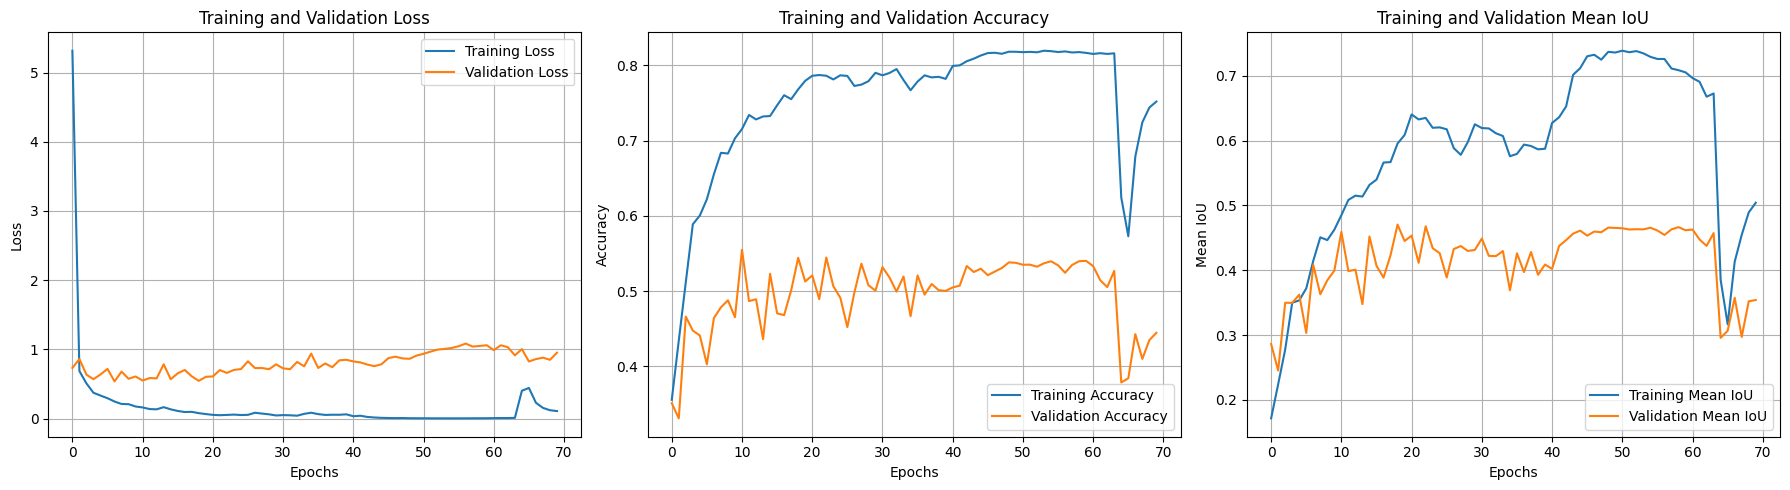

In [ ]:
visualize_training_results(history3, num_epochs)

## Evaluation: load the correspond checkpoint file and see the result

In [ ]:
!pip install gdown
! gdown --fuzzy https://drive.google.com/file/d/1b07r47gQSDXSrIGZPpu5uQG95Fv4q4lB/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1b07r47gQSDXSrIGZPpu5uQG95Fv4q4lB
From (redirected): https://drive.google.com/uc?id=1b07r47gQSDXSrIGZPpu5uQG95Fv4q4lB&confirm=t&uuid=0e3b378d-c65c-4326-9efc-551e019b0bbc
To: /content/best_model_multi_scale.pth
100% 38.9M/38.9M [00:00<00:00, 63.5MB/s]


In [ ]:
state_dict = torch.load('/content/best_model_multi_scale.pth')
model_ultra = EfficientRefineNetB0(num_classes=21).to(device)
model_ultra.load_state_dict(state_dict)
model_ultra.to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientRefineNetB0(
  (backbone): FeatureExtractor(
    (stem): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (activation): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (block0): MBConvBlock(
          (depsep): Sequential(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (se): SequentialSqueezeAndExcitation(
            (squeeze): Linear(in_features=32, out_features=8, bias=True)
            (expand): Linear(in_features=8, out_features=32, bias=True)
            (activation): SiLU(inplace=True)
            (sigmoid): Sigmoid()
            (mul_a_q

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
test_loss, test_accuracy, test_iou = evaluate_model(model_ultra, test_loader, loss_fn, NUM_VOC_CLASSES, ignore_index=255)
print(f'test Loss: {test_loss:.4f}, test Accuracy: {test_accuracy:.4f}, Val IoU: {test_iou:.4f}')

test Loss: 0.7054, test Accuracy: 0.8915, Val IoU: 0.5355


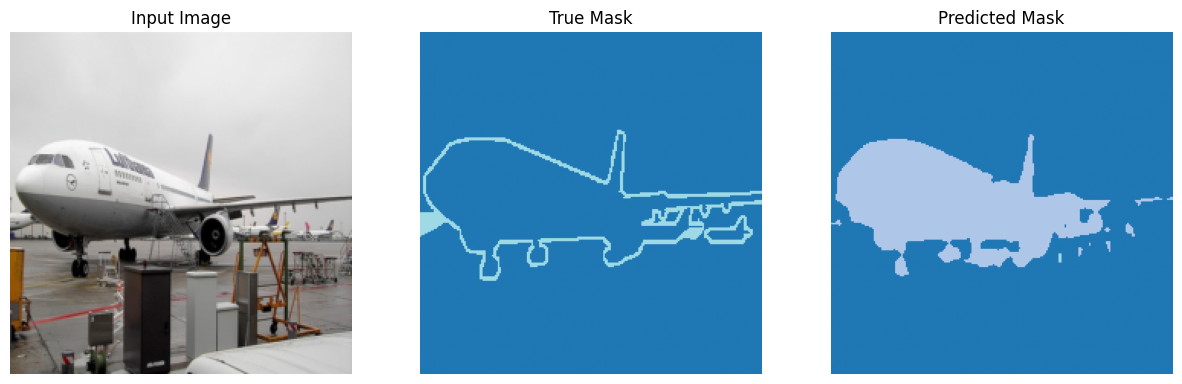

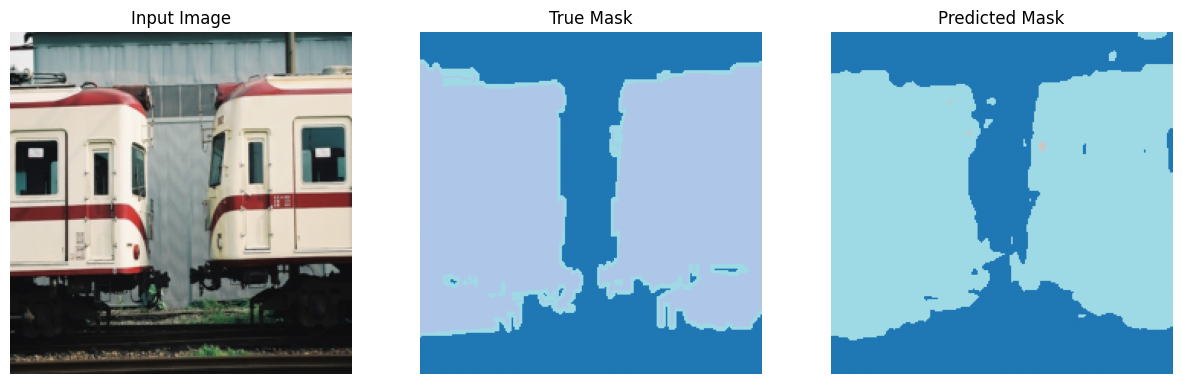

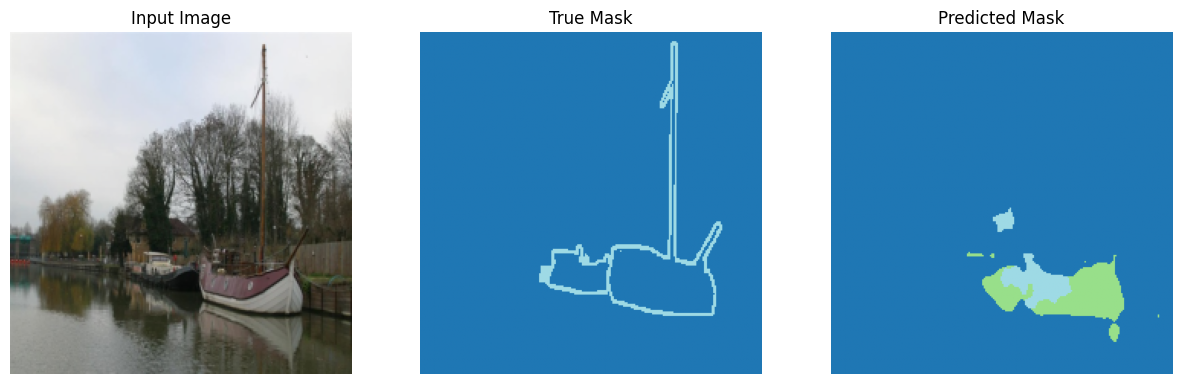

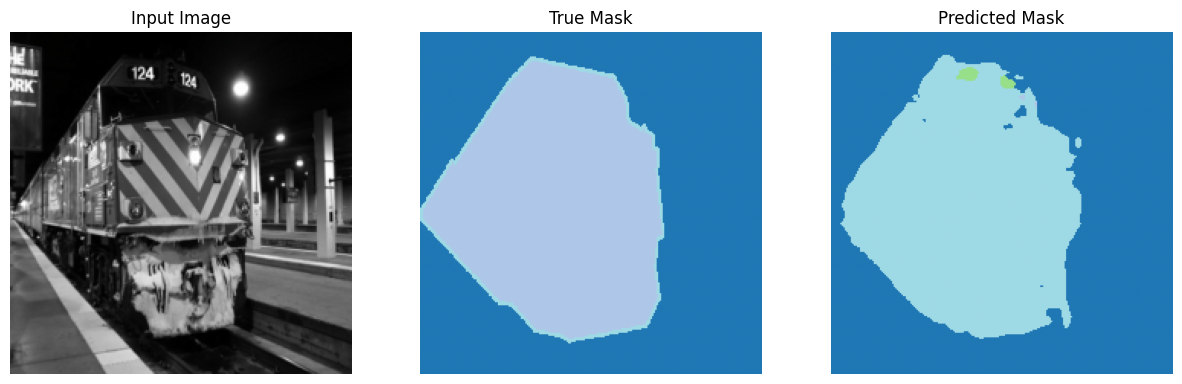

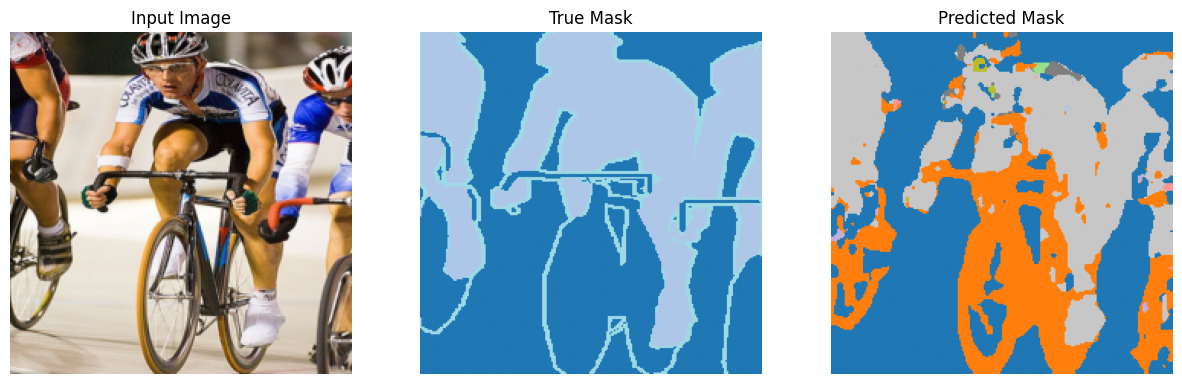

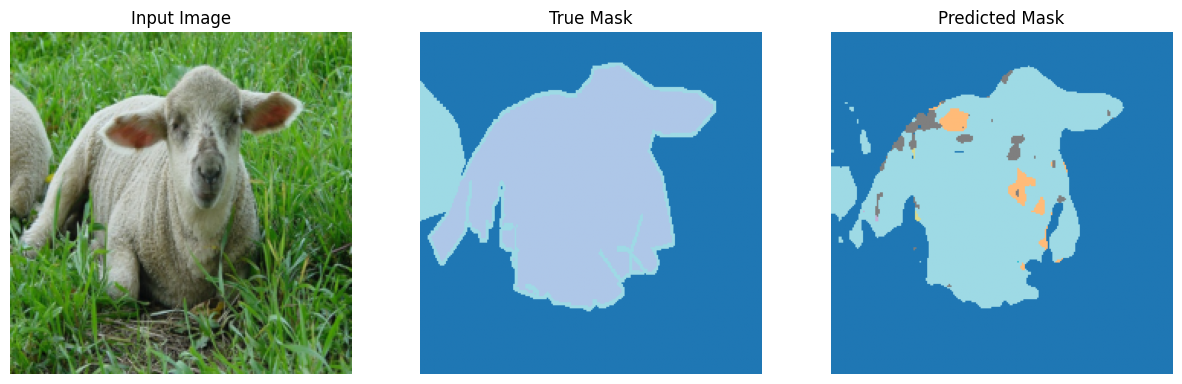

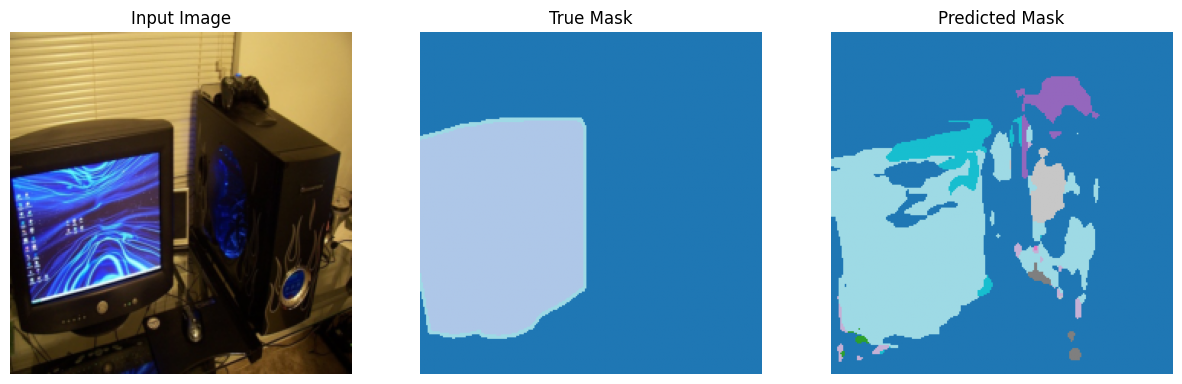

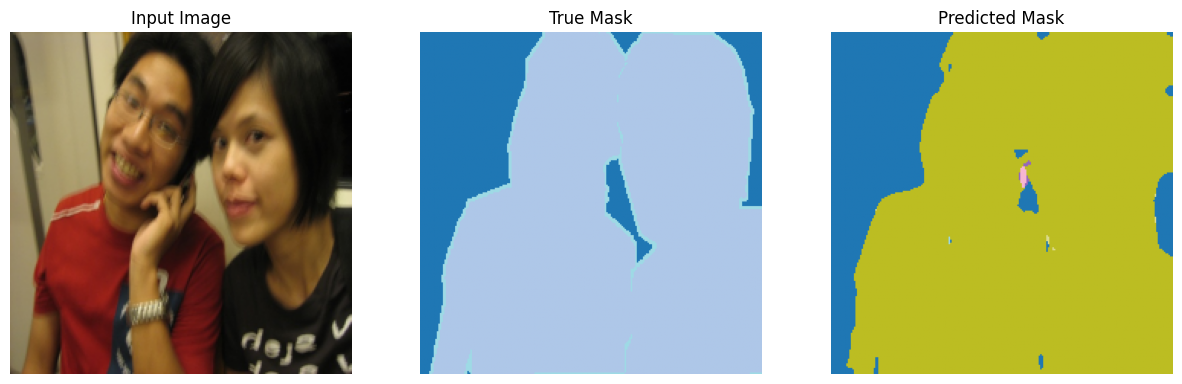

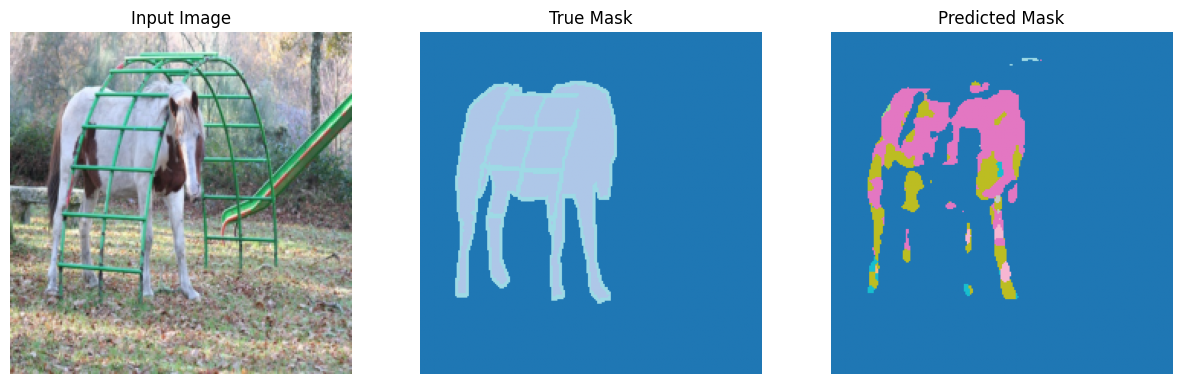

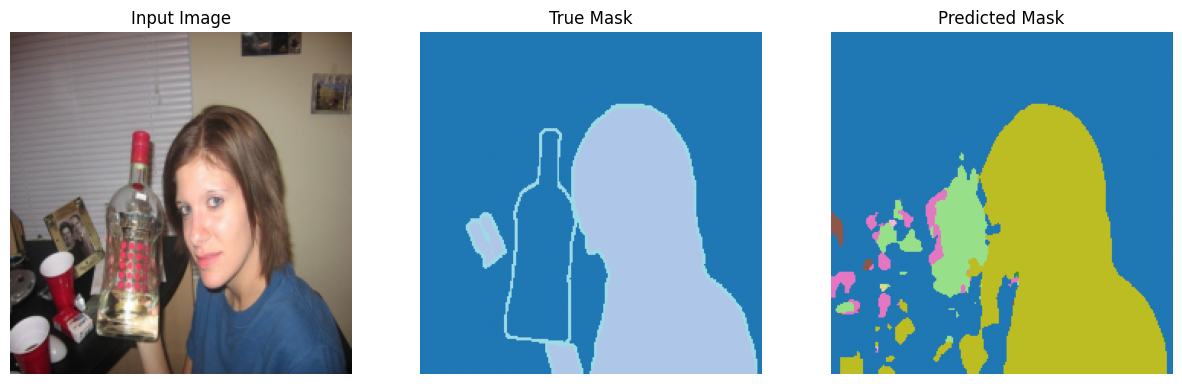

In [ ]:
predict(model_ultra, test_loader)